# 1. Introduction

使用Keras做5層CNN Model，並且啟用tensorflow-gpu來減少運算時間(GTX1060 6G)

以下包括
* data preparation
* CNN modeling and evaluation
* results prediction

## 1.1 import 所需工具
(pandas, numpy, matplotlib, seaborn, sklearn, keras, tensorflow)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7565969063714089835
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13252300499955431939
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4922553139
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9911922064550279588
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4746717099566939565
physical_device_desc: "device: XLA_GPU device"
]


# 2. Data preparation
## 2.1 載入Data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


D:\Anaconda3\anaconda3\envs\tensorflow-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

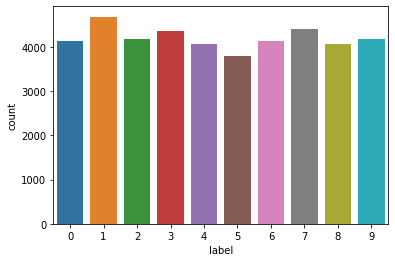

In [4]:
Y_train = train["label"]

X_train = train.drop(labels = ["label"],axis = 1) 

del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

We have similar counts for the 10 digits.

## 2.2 確認有無空值或遺失值
空值或缺失值會造成圖片損壞，因此需進行確認

In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## 2.3 Normalization(正規化)

In [7]:
X_train = X_train / 255.0
test = test / 255.0

## 2.3 Reshape
將一維data轉為3維圖片(height = 28px, width = 28px , canal = 1)

In [8]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## 2.5 Label encoding
將y_train轉成one-hot-encoding(ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

In [9]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [10]:
Y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## 2.6 資料切割(Train and Val)
將90%做為訓練集，10%做為驗證

In [11]:
random_seed = 2

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

視覺化訓練集中其中一張圖

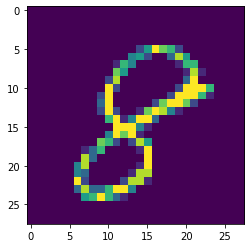

In [13]:
g = plt.imshow(X_train[0][:,:,0])

# 3. CNN
## 3.1 定義模型

[[Conv2D->relu]x2 -> MaxPool2D -> Dropout]x2 -> Flatten -> Dense -> Dropout -> Out

卷積層(Conv2D)，將原始圖片的與特定的Feature Detector(filter)做卷積運算，能夠將原圖之特徵取出。

池化層(MaxPool2D)，透過挑出範圍矩陣當中的最大值來壓縮圖片並保留重要資訊。

Dropout是丟棄一定比例的神經元參數來減少過度擬合。

Flatten層是將之前的結果平坦化之後接到最基本神經網路(ANN之類的)

Dense層中是人工神經網路(ANN)分類器。

In [14]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

## 3.2 設定optimizer與學習率調整
選擇Adam優化器，Adam集合了AdaGrad和RMSProp演算法的主要優點

損失函數categorical_crossentropy

In [16]:
# 定義優化器
optimizer = keras.optimizers.Adam(lr=0.001, epsilon=1e-08, decay=0.0)

In [17]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

為了使優化器收斂更快並且最接近損失函數的全局最小值，使用了學習率(LR)的動態調整方法。

定義學習率之後，經過一定epoch迭代之後模型效果可能停滯，該學習率可能已經不再適應該模型。需要在訓練過程中縮小學習率進而提升模型。我們可以使用keras中的ReduceLROnPlateau函數來動態調整學習率。

In [18]:
# 設定學習率動態調整
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
epochs = 40
batch_size = 86

## 3.3 Data augmentation(資料擴展) 

為了避免欠擬合(資料數量太少)與過擬合(形式過於單一)的問題，需要刻意擴展手寫數字數據集，可以使現有的資料集更多。
這個想法是通過變換原始訓練資料，以重現手寫數字時發生的變化。
例如:數字比例尺不同(字體大小)圖像旋轉等...

使用Keras中ImageDataGenerator函數來實現。

In [21]:
datagen = ImageDataGenerator(
        rotation_range=10,  # 影象旋轉 (0 to 180)
        zoom_range = 0.1, # 隨機縮放範圍 
        width_shift_range=0.1,  # 水平平移，相對總寬度的比例
        height_shift_range=0.1,  # 垂直平移，相對總高度的比例
        horizontal_flip=False,  # 隨機水平翻轉
        vertical_flip=False)  # 隨機垂直翻轉


datagen.fit(X_train)

沒有應用vertical_flip或horizontal_flip，因為可能導致對稱數字(例如6和9)進行錯誤分類。

In [22]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
439/439 - 8s - loss: 0.4342 - accuracy: 0.8592 - val_loss: 0.0652 - val_accuracy: 0.9814
Epoch 2/40
439/439 - 8s - loss: 0.1446 - accuracy: 0.9573 - val_loss: 0.0432 - val_accuracy: 0.9874
Epoch 3/40
439/439 - 8s - loss: 0.1020 - accuracy: 0.9698 - val_loss: 0.0397 - val_accuracy: 0.9895
Epoch 4/40
439/439 - 8s - loss: 0.0880 - accuracy: 0.9738 - val_loss: 0.0346 - val_accuracy: 0.9902
Epoch 5/40
439/439 - 8s - loss: 0.0749 - accuracy: 0.9776 - val_loss: 0.0275 - val_accuracy: 0.9924
Epoch 6/40
439/439 - 8s - loss: 0.0628 - accuracy: 0.9810 - val_loss: 0.0234 - val_accuracy: 0.9931
Epoch 7/40
439/439 - 8s - loss: 0.0640 - accuracy: 0.9817 - val_loss: 0.0283 - val_accuracy: 0.9912
Epoch 8/40
439/439 - 8s - loss: 0.0565 - accuracy: 0.9836 - val_loss: 0.0214 - val_accuracy: 0.9933
Epoch 9/40
439/439 - 8s - loss: 0.0533 - accuracy: 0.9837 - val_loss: 0.0196 - val_accuracy: 0.9929
Epoch 10/40
439/439 - 8s

# 4. Evaluate the model(模型評估)
## 4.1 Training and validation 曲線

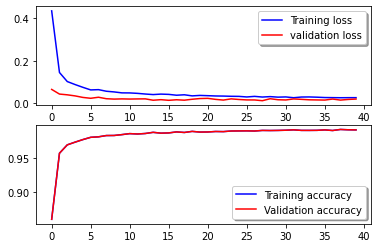

In [23]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

訓練過程中，準確率幾乎都是持續升高的。而訓練與驗證差距微小，這意味著我們的模型並沒有過度擬合。

## 4.2 Confusion matrix(混淆矩陣)

混淆矩陣對於查看模型結果的細節很有幫助，以下繪製了驗證結果的混淆矩陣。

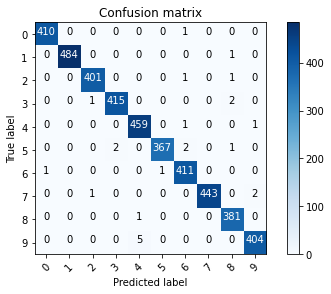

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 驗證集的分類值
Y_pred = model.predict(X_val)
# 分類結果轉成one hot 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 
# 計算混淆矩陣
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# 視覺化
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

以上為驗證結果之混淆矩陣，斜對角(深色部分)為分類正確的數量
例如:驗證集共有4200張圖，實際上是數字0而分類結果也為數字0的數量為410個。

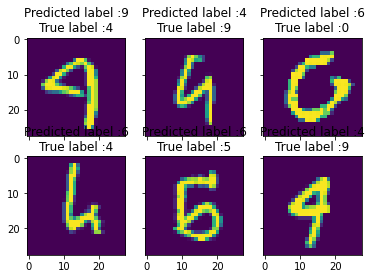

In [25]:
# 顯示一些分錯的例子
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]
# 顯示6個例子
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_dela_errors[-6:]

display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

這些錯誤其實是非常棘手的問題，其中一些錯誤也可能是人為造成的。
很多都是4與9的情況。例如:最後一個的9，我看起來就跟4沒兩樣。

In [26]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [27]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)